In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
#from visualization14 import ANN
#%matplotlib widget

In [2]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
from collections import Counter
# Visualization
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from torchvision.transforms import ToTensor
from torchvision.models import resnet18,resnet50
from torch import nn
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

## For trained weights

In [4]:
from torchvision import models
original_model = models.resnet18(pretrained=True)
#original_model.g
#original_model=models.alexnet(pretrained=True)
class ResNetMNIST(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet18(num_classes=10)
        self.model.weight='IMAGENET1K_V1'
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.loss = nn.CrossEntropyLoss()
        self.features = nn.Sequential(
                        # stop at conv4   get_features()
                      torch.nn.Sequential(*list(self.model.children())[:-1])# *list(original_model.features.children())[:-1]
                    )

    @auto_move_data
    def forward(self, x):
        return self.model(x),self.model(x)#torch.softmax(model(x), dim=1)

    def training_step(self, batch, batch_no):
        x, y = batch
        #print(x.size())
        _,logits = self(x)
        loss = self.loss(logits, y)
        return loss
    def validation_step(self, batch, batch_no):
        x, y = batch
        #print(x.size())
        _,logits = self(x)
        loss = self.loss(logits, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005)#RMSprop

In [5]:
#orig_model = ResNetMNIST()
model = ResNetMNIST()

In [6]:
trainer = pl.Trainer(
    #gpus=1,
    max_epochs=30,
    progress_bar_refresh_rate=20
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [7]:
import time
start_time = time.time()
if __name__ == "__main__":
    
    data_dir='./'
    # download
    MNIST(data_dir, train=True, download=True)
    MNIST(data_dir, train=False, download=True)
    transform = transforms.Compose([transforms.ToTensor()])
    dataset_full = MNIST(data_dir,train=True,transform=transform)
    dataset_train = MNIST(data_dir,train=True,transform=transform)
            
    #print(type(dataset_full),len(dataset_full)) 
    dataset_train, dataset_val,remaining = random_split(dataset_full, [60000,0,0])
    #print(len(dataset_train),type(dataset_train))
    dataset_train_original=copy.deepcopy(dataset_train)
    train_dl = DataLoader(dataset_train, batch_size=64, shuffle=True)
    #valid_dl = DataLoader(dataset_val, batch_size=64, shuffle=True)

    trainer.fit(model,train_dl)#,val_dataloaders=valid_dl)
Resnet_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\USER\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name     | Type             | Params
----------------------------------------------
0 | model    | ResNet           | 11.2 M
1 | loss     | CrossEntropyLoss | 0     
2 | features | Sequential       | 11.2 M
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

--- 45939.29618477821 seconds ---


## Shows some of MNIST data

In [8]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

In [9]:
import itertools
k = int(np.floor(sample_at/batch_size))
transform = transforms.Compose([transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

#plt.figure()
#for i in range(32):
#    plt.subplot(4,8,i+1)
#    arr=np.squeeze(data)
#    plt.imshow(my_sample[0][i][0], cmap='gray')
#    plt.axis('off')
#    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

tensor([1, 3, 9, 6, 2, 7, 0, 7, 9, 7, 1, 9, 8, 3, 9, 0, 7, 8, 7, 3, 4, 1, 7, 5,
        9, 4, 9, 1, 8, 3, 9, 0])


## prepare_test_embeddings

In [10]:
def prepare_test_embeddings(dataset_train):
    #model=my_model
    transform = transforms.Compose([transforms.ToTensor()])
    data=dataset_train
    dataloader = DataLoader(data, batch_size=32)
    test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 10), dtype=torch.float32)
    #c=0
    #print(len(dataloader))
    for x,y in dataloader:
     #   print(c)
        #c=c+1
        x = x.cpu()
        embeddings, logits = model(x)#orig_model(x)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        test_predictions.extend(predicted_class.detach().cpu().tolist())
        test_targets.extend(y.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_embeddings = torch.cat((test_embeddings, embeddings), 0)
        test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
        #print('Y',y.detach().cpu().tolist())
    test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    #print(test_predictions == test_targets)
    test_acc = np.sum(test_predictions == test_targets)
    
    accuracy = accuracy_score(test_predictions, test_targets)#,average='micro')
    recall = recall_score(test_predictions, test_targets,average='micro')
    precision = precision_score(test_predictions, test_targets,average='micro')
    f1_score1 = f1_score(test_predictions, test_targets,average='micro')
    
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'precision: {precision*100:.2f}%')
    print(f'recall: {recall*100:.2f}%')
    print(f'f1_score1: {f1_score1*100:.2f}%')
    
    final_test_acc = test_acc/len(test_embeddings)
    
    return test_embeddings,test_targets,test_predictions,final_test_acc

In [11]:
# calculates precision for 1:100 dataset with 90 tp and 30 fp
from sklearn.metrics import precision_score,accuracy_score
# calculates recall for 1:100 dataset with 90 tp and 10 fn
from sklearn.metrics import recall_score
# calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
from sklearn.metrics import f1_score

In [12]:
data_test = MNIST(".", train=False, download=True, transform=transform)
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Accuracy: 98.97%
precision: 98.97%
recall: 98.97%
f1_score1: 98.97%
Initial Testing accuracy:   0.9897


# Kmeans ++

In [129]:
def all_list(test_embeddings,test_targets,data):
    test_embeddings=test_embeddings
    test_targets=test_targets
    list1,data1=[],[]
    list2,data2=[],[]
    list3,data3=[],[]
    list4,data4=[],[]
    list5,data5=[],[]
    list6,data6=[],[]
    list7,data7=[],[]
    list8,data8=[],[]
    list9,data9=[],[]
    list10,data10=[],[]
    i=0
    for embeddings in test_embeddings:
        if test_targets[i]==0:
            list1.append(embeddings)
            data1.append(data[i])
        if test_targets[i]==1:
            list2.append(embeddings)
            data2.append(data[i])
        if test_targets[i]==2:
            list3.append(embeddings)
            data3.append(data[i])
        if test_targets[i]==3:
            list4.append(embeddings)
            data4.append(data[i])
        if test_targets[i]==4:
            list5.append(embeddings)
            data5.append(data[i])
        if test_targets[i]==5:
            list6.append(embeddings)
            data6.append(data[i])
        if test_targets[i]==6:
            list7.append(embeddings)
            data7.append(data[i])
        if test_targets[i]==7:
            list8.append(embeddings)
            data8.append(data[i])
        if test_targets[i]==8:
            list9.append(embeddings)
            data9.append(data[i])
        if test_targets[i]==9:
            list10.append(embeddings)
            data10.append(data[i])
        i=i+1
    all_lists=[]
    all_data=[]
    list1,data1=np.array(list1),np.array(data1)
    all_lists.append(list1),all_data.append(data1)
    
    list2,data2=np.array(list2),np.array(data2)
    all_lists.append(list2),all_data.append(data2)
    
    list3,data3=np.array(list3),np.array(data3)
    all_lists.append(list3),all_data.append(data3)
    
    list4,data4=np.array(list4),np.array(data4)
    all_lists.append(list4),all_data.append(data4)
    
    list5,data5=np.array(list5),np.array(data5)
    all_lists.append(list5),all_data.append(data5)
    
    list6,data6=np.array(list6),np.array(data6)
    all_lists.append(list6),all_data.append(data6)
    
    list7,data7=np.array(list7),np.array(data7)
    all_lists.append(list7),all_data.append(data7)
    
    list8,data8=np.array(list8),np.array(data8)
    all_lists.append(list8),all_data.append(data8)
    
    list9,data9=np.array(list9),np.array(data9)
    all_lists.append(list9),all_data.append(data9)
    
    list10,data10=np.array(list10),np.array(data10)
    all_lists.append(list10),all_data.append(data10)
    
    print(list10.shape, len(list9),len(all_lists))
    return all_lists,all_data
#all_lists=all_list(test_embeddings2,test_targets2)
#all_lists=all_list(all_np,labels)

Prepare test embeddings for all data  

# extract embeddings of 200 training data to get the center points

In [130]:
len(dataset_train)

200

In [131]:
dataset_full2, remaning = random_split(dataset_train, [len(dataset_train),0])

In [132]:
test_embeddings,test_targets,test_predictions,final_test_acc=prepare_test_embeddings(dataset_train)

In [133]:
temb_test_embeddings_copy=test_embeddings
dataset_full2_copy=dataset_full2
test_targets_copy=test_targets
test_predictions_copy=test_predictions

# visualize the ditribution of Random 200 points 

In [134]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 4.002784
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.962090
[t-SNE] KL divergence after 1000 iterations: 0.319060


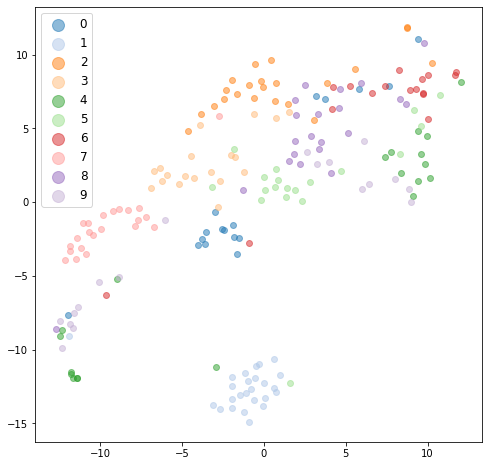

In [135]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# To Get only the correct data prediction  

In [136]:
def get_correct_embeddings(temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy):
    c=0
    print(len(temb_test_embeddings_copy))
    for i in range(len(temb_test_embeddings_copy)):
        try:
            if test_targets_copy[i]!=test_predictions_copy[i]:
                print(i)
                temb_test_embeddings_copy=np.delete(temb_test_embeddings_copy,i-c,axis=0)
                dataset_full2_copy=np.delete(dataset_full2_copy,i-c,axis=0)
                test_targets_copy=np.delete(test_targets_copy,i-c,axis=0)
                test_predictions_copy=np.delete(test_predictions_copy,i-c,axis=0)
                c=c+1
        except:
            print("")
    print(len(temb_test_embeddings_copy))
    return temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy
print(len(temb_test_embeddings_copy))

200


In [137]:
test_embeddings=temb_test_embeddings_copy
dataset_full2=dataset_full2_copy
test_targets=test_targets_copy
dataset_train_original2=dataset_full2

In [138]:
all_lists,all_data_points=all_list(test_embeddings,test_targets,dataset_full2)

(18, 10) 21 10


<ipython-input-129-3f24519255a4>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-129-3f24519255a4>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-129-3f24519255a4>:52: FutureWarning: The input object of type 'Tensor' is an array-like implementin

In [139]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [140]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(test_embeddings) 
kmeans.labels_

array([3, 5, 0, 5, 0, 0, 5, 0, 3, 0, 4, 4, 0, 0, 4, 5, 9, 4, 3, 6, 8, 7,
       4, 8, 5, 0, 0, 7, 8, 4, 3, 7, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 4, 7,
       0, 0, 5, 3, 6, 9, 0, 5, 5, 2, 5, 0, 0, 3, 3, 0, 4, 0, 0, 4, 7, 0,
       4, 0, 3, 4, 0, 4, 0, 6, 4, 4, 5, 0, 0, 3, 7, 9, 0, 3, 4, 5, 5, 9,
       3, 0, 4, 5, 7, 0, 4, 0, 0, 4, 0, 5, 0, 0, 2, 7, 0, 3, 2, 9, 7, 0,
       7, 0, 1, 5, 3, 0, 0, 0, 3, 7, 4, 9, 7, 7, 0, 4, 7, 0, 4, 7, 5, 4,
       5, 0, 3, 0, 7, 0, 3, 4, 2, 9, 3, 2, 5, 9, 0, 2, 3, 9, 8, 7, 4, 4,
       4, 2, 3, 5, 4, 5, 0, 7, 9, 0, 0, 0, 2, 0, 0, 4, 0, 5, 2, 4, 9, 9,
       3, 0, 0, 4, 3, 5, 4, 3, 5, 5, 3, 0, 4, 3, 1, 0, 4, 9, 8, 2, 4, 7,
       5, 4])

In [141]:
len(kmeans.cluster_centers_)

10

In [142]:
all_clusters=kmeans.cluster_centers_

In [143]:
import math
import scipy.spatial as sp
import numpy as np
def get_dist(a,b):
    reslt=sp.distance.cosine(a,b)
    return reslt

In [144]:
len(test_embeddings)

200

# assign center point for each class 

In [145]:
center_classes=[]
for clas in all_lists:
    for cluster in all_clusters:
        p=cluster
        n = len(clas)
        dist = math.inf #(infinity)
        temb_test_embeddings=clas#.copy()
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
    center_classes.append(np1)
    indx=np.where(all_clusters==cluster)
    all_clusters=np.delete(all_clusters,indx[0][0],axis=0)
    print(len(all_clusters))
len(center_classes)

9
8
7
6
5
4
3
2
1
0


10

# get 10 neighbours for each class to perform (200 initial points)

In [146]:
points_class0=[]
points_class1=[]
points_class2=[]
points_class3=[]
points_class4=[]
points_class5=[]
points_class6=[]
points_class7=[]
points_class8=[]
points_class9=[]
all_points=[]
all_points.append(points_class0)
all_points.append(points_class1)
all_points.append(points_class2)
all_points.append(points_class3)
all_points.append(points_class4)
all_points.append(points_class5)
all_points.append(points_class6)
all_points.append(points_class7)
all_points.append(points_class8)
all_points.append(points_class9)


points_dist0=[]
points_dist1=[]
points_dist2=[]
points_dist3=[]
points_dist4=[]
points_dist5=[]
points_dist6=[]
points_dist7=[]
points_dist8=[]
points_dist9=[]
all_dist=[]
all_dist.append(points_dist0)
all_dist.append(points_dist1)
all_dist.append(points_dist2)
all_dist.append(points_dist3)
all_dist.append(points_dist4)
all_dist.append(points_dist5)
all_dist.append(points_dist6)
all_dist.append(points_dist7)
all_dist.append(points_dist8)
all_dist.append(points_dist9)

In [147]:
all_np=[]
for lab in range(10):
    p=center_classes[lab]
    n = len(all_lists[lab])
    dist = math.inf #(infinity)
    temb_test_embeddings=all_lists[lab]#kmeans.labels_
    for c in range(10): 
        n = len(temb_test_embeddings)
        dist = math.inf
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
        all_np.append(np1)
        indx=np.where(temb_test_embeddings==np1)
        print(len(temb_test_embeddings))
        
        temb_test_embeddings=np.delete(temb_test_embeddings,indx[0][0],axis=0)
        dataset_train_original2=np.delete(dataset_train_original2,indx[0][0],axis=0)
        
        
    n = len(temb_test_embeddings)
    dist = math.inf
    for i in range(n):
        d = get_dist(p,temb_test_embeddings[i])
        all_points[lab].append(all_data_points[lab][i])
        all_dist[lab].append(d)
len(all_np)

17
16
15
14
13
12
11
10
9
8
25
24
23
22
21
20
19
18
17
16
22
21
20
19
18
17


C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


16
15
14
13
19
18
17
16
15
14
13
12
11
10
20
19
18
17
16
15
14
13
12
11
19
18
17
16
15
14
13
12
11
10
17
16
15
14
13
12
11
10
9
8
22
21
20
19
18
17
16
15
14
13
21
20
19
18
17
16
15
14
13
12
18
17
16
15
14
13
12
11
10
9


100

# get the original images (as core_data) corrosponding to the 100 center points

In [148]:
indx=np.where(test_embeddings==all_np[0])
core_data1=dataset_full2[indx[0][0]]
core_data1,t=random_split([core_data1],[1,0])
core_data1=tuple(core_data1)
for point in all_np[1:]: 
    indx=np.where(test_embeddings==point)
    arr=dataset_full2[indx[0][0]]
    arr,t=random_split([arr],[1,0])
    arr=tuple(arr)
    core_data1=torch.utils.data.ConcatDataset([arr,core_data1])

In [149]:
core_data=core_data1
len(core_data)

100

# Embeddings of 100 core-set

In [150]:
test_embeddings2,test_targets2,test_predictions2,final_test_acc2=prepare_test_embeddings(core_data)

In [151]:
test_embeddings2,core_data,test_targets2,test_predictions2=get_correct_embeddings(test_embeddings2,core_data,test_targets2,test_predictions2)

100
1
3
7
9
10
15
18
19
28
29
30
31
34
35
37
39
43
47
48
49
51
53
54
55
62
64
69



























73


# visualize the ditribution of 100 core_data 

In [152]:
tsne = TSNE(2, verbose=1)
tsne_proj_core = tsne.fit_transform(test_embeddings2)
#tsne_proj = tsne.fit_transform(core_data.datasets[1])

[t-SNE] Computing 72 nearest neighbors...
[t-SNE] Indexed 73 samples in 0.000s...
[t-SNE] Computed neighbors for 73 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 73 / 73
[t-SNE] Mean sigma: 6.137604
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.836994
[t-SNE] KL divergence after 1000 iterations: 0.114209


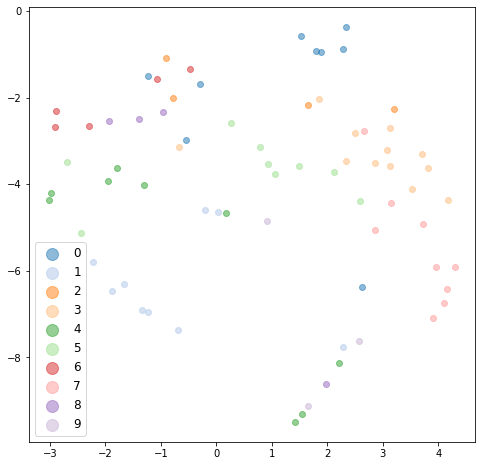

In [153]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets2==lab
    ax.scatter(tsne_proj_core[indices,0],tsne_proj_core[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### **For one class SVM**

In [154]:
all_lists,_=all_list(test_embeddings2,test_targets2,core_data)

(3, 10) 4 10


In [155]:
X_train=np.concatenate((all_lists[9],all_lists[8],all_lists[7],all_lists[6],all_lists[5],all_lists[4],all_lists[3],all_lists[2],all_lists[1],all_lists[0]),axis=0)
len(X_train)

73

In [156]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.05, kernel = 'rbf', gamma = 'scale').fit(X_train)

In [157]:
def do_predict(dataset_train):
    #model=my_model
    transform = transforms.Compose([transforms.ToTensor()])
    data=dataset_train
    dataloader = DataLoader(data, batch_size=32)
    test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 10), dtype=torch.float32)
    #c=0
    #print(len(dataloader))
    for x,y in dataloader:
     #   print(c)
        #c=c+1
        x = x.cpu()
        embeddings, logits = model(x)#orig_model(x)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        test_predictions.extend(predicted_class.detach().cpu().tolist())
        test_targets.extend(y.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_embeddings = torch.cat((test_embeddings, embeddings), 0)
        test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
        #print('Y',y.detach().cpu().tolist())
    test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    #print(test_predictions == test_targets)
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    
    return final_test_acc,test_targets,test_embeddings

In [158]:
dataset_full2 = tuple([tuple(e) for e in dataset_full2])
len(dataset_full2)

200

# Just to visualize outlier prediction (Take one example)

In [159]:
dd1,remaning = random_split(dataset_full2, [100,len(dataset_full2)-100])
# do prediction 
_,t_targets3,t_embeddings3=do_predict(dd1)

In [160]:
len(dd1)

100

In [161]:
prediction = one_class_svm.predict(t_embeddings3)
prediction = [1 if i==-1 else 0 for i in prediction]

In [162]:
all_prediction=prediction

# visualization of OneSvm 

In [163]:
core_data=tuple([tuple(e) for e in core_data])

In [164]:
#temb_training=torch.utils.data.ConcatDataset([core_data,temb_training])#core_data
test_embeddings4,test_targets4,_,_=prepare_test_embeddings(core_data)
print(len(test_embeddings4))

73


In [165]:
#do predict on one SVM
prediction2 = one_class_svm.predict(test_embeddings4)
# Change the anomalies' values to make it consistent with the true values
prediction2 = [1 if i==-1 else 0 for i in prediction2]
#print("The result of outlier is ",prediction)

In [166]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings4)

[t-SNE] Computing 72 nearest neighbors...
[t-SNE] Indexed 73 samples in 0.000s...
[t-SNE] Computed neighbors for 73 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 73 / 73
[t-SNE] Mean sigma: 5.978772
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.642948
[t-SNE] KL divergence after 1000 iterations: 0.109450


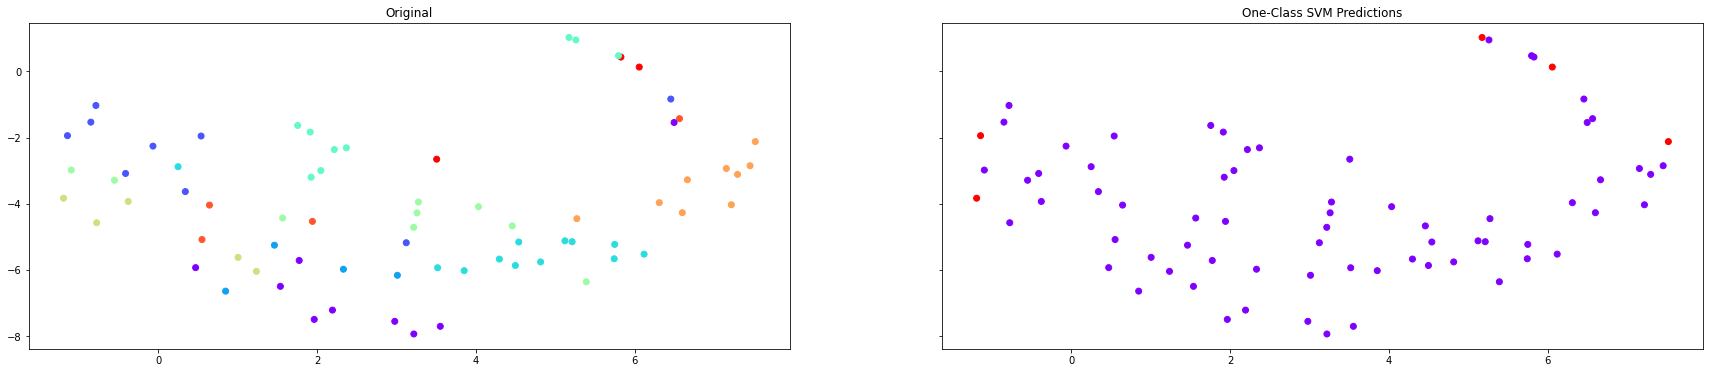

In [167]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(tsne_proj, columns=['feature1', 'feature2'])
df_test['y_test'] = test_targets4#test_targets4
df_test['one_class_svm_prediction'] = prediction2


df_core = pd.DataFrame(tsne_proj_core, columns=['feature1', 'feature2'])
df_core['y_test'] = test_targets2

fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(30,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')


# start iterations 

In [168]:
data_test = MNIST(".", train=False, download=True, transform=transform)

In [169]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)

In [170]:
final_test_acc

0.5834

In [171]:
dataset_full2_copy=remaining
dataset_train=dataset_train_original#core_data

In [172]:
import time
start_time = time.time()
CNN_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [173]:
pred_list_val=[]
pred_list_train=[]
pred_list_test=[]
all_outliers=[]
len_outliers=[]
Times=[]

In [174]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
pred_list_test.append(final_test_acc)

In [175]:
#pred_list_val.append(trainer.callback_metrics["val_acc"])
#pred_list_train.append(trainer.callback_metrics["train_acc"])
pred_list_test.append(final_test_acc)
Times.append(CNN_time)
len_outliers.append(200)

In [176]:
remaining=dataset_full2_copy

In [177]:
len(remaining)

59800

In [178]:
one_class_svm = OneClassSVM(nu=0.0005, kernel = 'poly', gamma ='auto').fit(test_embeddings)

# give an outlier score for all 49800 unlabeled training data and then take the highest 100 points in each round

In [179]:
kernel = 'poly'
gamma = 'auto'
NU=0.001

roud=0
nu_out=200
while final_test_acc<0.98:
#for c in range(2):
    start_time = time.time()
    #one_class_svm = OneClassSVM(nu=0.5, kernel = 'rbf', gamma = 'scale').fit(X_train)
    _,_,test_embeddings=do_predict(remaining)
    whole_prediction=one_class_svm.predict(test_embeddings)
    Scores=one_class_svm.score_samples(test_embeddings)
    len_out=0
    for out1 in whole_prediction:
        if out1==1:
            len_out=len_out+1
    print(len_out)
    df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
    df_remaining.sort_values(by=['Score'], inplace=True,ascending=True)
    Whole_outliers=torch.utils.data.ConcatDataset([[],[]])
    
    if roud>=4:
        nu_out=100
    for i in range(nu_out):
        Whole_outliers=torch.utils.data.ConcatDataset([[(df_remaining['Remaining'][i][0],df_remaining['Remaining'][i][1])]
                                                   ,Whole_outliers])
        indx=np.where(test_embeddings==df_remaining['embeddings'][i])
        #print(indx)
        remaining=np.delete(remaining,indx[0][0],axis=0)
    remaining=tuple([tuple(e) for e in remaining])
    remaining=torch.utils.data.ConcatDataset([remaining,[]])
    
    dataset_train=torch.utils.data.ConcatDataset([Whole_outliers,dataset_train])
    print('All Remaining',len(remaining))
    #print('dataset_train_temp>>>>>>>>',len(dataset_train_temb))
    
    train_dl = DataLoader(dataset_train, batch_size=64, shuffle=True)
    #model.setup(dataset_train,dataset_val,stage='fit')
    #model.dataset_val=dataset_val
    #trainer = pl.Trainer(
    #                     max_epochs=20,
    #                     progress_bar_refresh_rate=10,
    #                     callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model,train_dl)
    
    print('Gooooood their is valuable data')
    len_outliers.append(100)


    #print(len(outlier),'......',i)
    #print(trainer.callback_metrics["val_acc"])
    #pred_list_val.append(trainer.callback_metrics["val_acc"])
    #pred_list_train.append(trainer.callback_metrics["train_acc"])

    
    _,_,_,final_test_acc=prepare_test_embeddings(data_test)
    pred_list_test.append(final_test_acc)
    # repeat one SVM
    #prepaire the new test_embeddings


    test_embeddings,test_targets,_,_=prepare_test_embeddings(dataset_train)
    print(len(test_embeddings),final_test_acc)
    
    one_class_svm = OneClassSVM(nu=NU, kernel = kernel, gamma =gamma).fit(test_embeddings)
    CNN_time = time.time() - start_time
    print("--- %s seconds ---" % (time.time() - start_time))
    Times.append(CNN_time)
    roud=roud+1

59575


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59600


Training: 3it [00:00, ?it/s]

Gooooood their is valuable data
400 0.2887
--- 1107.8165731430054 seconds ---
59396


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59400


Training: 6it [00:00, ?it/s]

Gooooood their is valuable data
600 0.3331
--- 1049.7536878585815 seconds ---
58370


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59200


Training: 9it [00:00, ?it/s]

Gooooood their is valuable data
800 0.4774
--- 1217.7781291007996 seconds ---
58800


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 59000


Training: 12it [00:00, ?it/s]

Gooooood their is valuable data
1000 0.5816
--- 1090.543200492859 seconds ---
58540


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58900


Training: 15it [00:00, ?it/s]

Gooooood their is valuable data
1100 0.7709
--- 1070.5517814159393 seconds ---
58560


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58800


Training: 17it [00:00, ?it/s]

Gooooood their is valuable data
1200 0.8907
--- 1014.8920331001282 seconds ---
58301


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58700


Training: 18it [00:00, ?it/s]

Gooooood their is valuable data
1300 0.8537
--- 1006.6898086071014 seconds ---
58483


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58600


Training: 20it [00:00, ?it/s]

Gooooood their is valuable data
1400 0.9041
--- 1013.2198956012726 seconds ---
58246


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58500


Training: 21it [00:00, ?it/s]

Gooooood their is valuable data
1500 0.9107
--- 997.0760035514832 seconds ---
58066


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58400


Training: 23it [00:00, ?it/s]

Gooooood their is valuable data
1600 0.9231
--- 1033.397221326828 seconds ---
58075


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58300


Training: 24it [00:00, ?it/s]

Gooooood their is valuable data
1700 0.9156
--- 1035.2853229045868 seconds ---
58112


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58200


Training: 26it [00:00, ?it/s]

Gooooood their is valuable data
1800 0.8716
--- 1012.4459452629089 seconds ---
58079


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58100


Training: 28it [00:00, ?it/s]

Gooooood their is valuable data
1900 0.9328
--- 1036.208770275116 seconds ---
57857


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 58000


Training: 29it [00:00, ?it/s]

Gooooood their is valuable data
2000 0.9358
--- 1033.1884310245514 seconds ---
57775


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57900


Training: 31it [00:00, ?it/s]

Gooooood their is valuable data
2100 0.942
--- 1048.6145453453064 seconds ---
57684


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57800


Training: 32it [00:00, ?it/s]

Gooooood their is valuable data
2200 0.8613
--- 1028.3820447921753 seconds ---
57650


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57700


Training: 34it [00:00, ?it/s]

Gooooood their is valuable data
2300 0.9452
--- 1079.2545986175537 seconds ---
57248


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57600


Training: 35it [00:00, ?it/s]

Gooooood their is valuable data
2400 0.9427
--- 1057.6155626773834 seconds ---
57453


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57500


Training: 37it [00:00, ?it/s]

Gooooood their is valuable data
2500 0.9475
--- 1069.5443420410156 seconds ---
57301


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57400


Training: 39it [00:00, ?it/s]

Gooooood their is valuable data
2600 0.9494
--- 1079.848435163498 seconds ---
57252


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57300


Training: 40it [00:00, ?it/s]

Gooooood their is valuable data
2700 0.9275
--- 1051.9163148403168 seconds ---
57258


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57200


Training: 42it [00:00, ?it/s]

Gooooood their is valuable data
2800 0.9507
--- 1061.3469076156616 seconds ---
57123


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57100


Training: 43it [00:00, ?it/s]

Gooooood their is valuable data
2900 0.9432
--- 1066.76593875885 seconds ---
57014


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 57000


Training: 45it [00:00, ?it/s]

Gooooood their is valuable data
3000 0.9489
--- 1071.463769197464 seconds ---
56863


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56900


Training: 46it [00:00, ?it/s]

Gooooood their is valuable data
3100 0.9554
--- 1064.1750783920288 seconds ---
56825


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56800


Training: 48it [00:00, ?it/s]

Gooooood their is valuable data
3200 0.9544
--- 1082.9038183689117 seconds ---
56732


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56700


Training: 49it [00:00, ?it/s]

Gooooood their is valuable data
3300 0.9568
--- 1074.5944216251373 seconds ---
56570


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56600


Training: 51it [00:00, ?it/s]

Gooooood their is valuable data
3400 0.9311
--- 1065.5928299427032 seconds ---
56433


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56500


Training: 53it [00:00, ?it/s]

Gooooood their is valuable data
3500 0.9533
--- 1076.4516530036926 seconds ---
56391


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56400


Training: 54it [00:00, ?it/s]

Gooooood their is valuable data
3600 0.9378
--- 1083.3059380054474 seconds ---
56267


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56300


Training: 56it [00:00, ?it/s]

Gooooood their is valuable data
3700 0.9582
--- 1112.6280834674835 seconds ---
56054


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56200


Training: 57it [00:00, ?it/s]

Gooooood their is valuable data
3800 0.9623
--- 1124.4051415920258 seconds ---
56032


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56100


Training: 59it [00:00, ?it/s]

Gooooood their is valuable data
3900 0.9587
--- 1095.070589542389 seconds ---
55923


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 56000


Training: 60it [00:00, ?it/s]

Gooooood their is valuable data
4000 0.9605
--- 1100.6960270404816 seconds ---
55773


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 55900


Training: 62it [00:00, ?it/s]

Gooooood their is valuable data
4100 0.9507
--- 1142.367692232132 seconds ---
55748


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 55800


Training: 64it [00:00, ?it/s]

Gooooood their is valuable data
4200 0.9661
--- 1113.505132675171 seconds ---
55736


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 55700


Training: 65it [00:00, ?it/s]

Gooooood their is valuable data
4300 0.9628
--- 1095.4194872379303 seconds ---
55622


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 55600


Training: 67it [00:00, ?it/s]

Gooooood their is valuable data
4400 0.9664
--- 1150.6838066577911 seconds ---
55465


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 55500


Training: 68it [00:00, ?it/s]

Gooooood their is valuable data
4500 0.9688
--- 1207.8320133686066 seconds ---
55303


<ipython-input-179-1511ad699e67>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 55400


Training: 70it [00:00, ?it/s]

Gooooood their is valuable data
4600 0.9639
--- 1673.9377281665802 seconds ---


KeyboardInterrupt: 

In [180]:
all_data=[pred_list_test[:],len_outliers[:],Times[:]]
all_info=pd.DataFrame(all_data)
all_info=all_info.T
all_info.columns=['Test ACC','Length of outliers','Time']
all_info

,Test ACC,Length of outliers,Time
0,0.5834,200.0,0.000000
1,0.5834,100.0,1107.816573
2,0.2887,100.0,1049.753688
3,0.3331,100.0,1217.778129
4,0.4774,100.0,1090.543200
5,0.5816,100.0,1070.551781
6,0.7709,100.0,1014.892033
7,0.8907,100.0,1006.689809
8,0.8537,100.0,1013.219896
9,0.9041,100.0,997.076004


In [181]:
all_info.to_csv('1ResNet-MNIST(nu=0.0005-then-0.001, kernel = poly, gamma =auto,nu_out=100)with scores_asceding=True.csv')